«Анализ данных о сердечно-сосудистых заболеваниях (поиск инсайтов, составление рекомендаций стейкхолдерам)»

Описание данных и подготовительные работы:

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from openpyxl import load_workbook
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import numpy as np

In [6]:
df = pd.read_csv('C:/Users/sanar/Desktop/cardio_train.csv', sep = ';')
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


1. Очистка данных:

1.1 Преобразование столбца age

In [12]:
def age(par):
    par = par // 365.25    ## перевод из дней в года
    return int(par)

## Применение функции
df['age'] = df['age'].apply(age)
df

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,2,51,1,165,64.0,130,70,3,1,0,0,0,1
3,3,48,2,169,82.0,150,100,1,1,0,0,1,1
4,4,47,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,99993,52,2,168,76.0,120,80,1,1,1,0,1,0
69996,99995,61,1,158,126.0,140,90,2,2,0,0,1,1
69997,99996,52,2,183,105.0,180,90,3,1,0,1,0,1
69998,99998,61,1,163,72.0,135,80,1,2,0,0,0,1


1.2 Удаление выбросов и ложных значений

In [15]:
df = df.loc[df['ap_hi'] >= 84]
df = df.loc[df['ap_hi'] <= 180]
df = df.loc[df['ap_lo'] >= 45]
df = df.loc[df['ap_lo'] <= 110]
df

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,2,51,1,165,64.0,130,70,3,1,0,0,0,1
3,3,48,2,169,82.0,150,100,1,1,0,0,1,1
4,4,47,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,99993,52,2,168,76.0,120,80,1,1,1,0,1,0
69996,99995,61,1,158,126.0,140,90,2,2,0,0,1,1
69997,99996,52,2,183,105.0,180,90,3,1,0,1,0,1
69998,99998,61,1,163,72.0,135,80,1,2,0,0,0,1


In [17]:
def ap(par):    ## Отбрасываем строки где значения диастолического и систолического давления имеют слишком большую разницу
    hi = par['ap_hi']
    lo = par['ap_lo']
    if (hi > lo) and ((hi - lo >= 30) and (hi - lo <= 70)):    ## Разницу от 30 до 70 считать нормой для жизнеспособности
        return True
    else:
        return False

## Применение функции
df['ap'] = df.apply(ap, axis = 1)
df = df.loc[df['ap'] == True]
df = df.drop('ap', axis = 1)
df

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,2,51,1,165,64.0,130,70,3,1,0,0,0,1
3,3,48,2,169,82.0,150,100,1,1,0,0,1,1
4,4,47,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69994,99992,57,1,165,80.0,150,80,1,1,0,0,1,1
69995,99993,52,2,168,76.0,120,80,1,1,1,0,1,0
69996,99995,61,1,158,126.0,140,90,2,2,0,0,1,1
69998,99998,61,1,163,72.0,135,80,1,2,0,0,0,1


In [18]:
def weight(par):    # Меняем тип на int для дальнейшего удобства
    return int(par)

## Применение функции
df['weight'] = df['weight'].apply(weight)
df

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50,2,168,62,110,80,1,1,0,0,1,0
1,1,55,1,156,85,140,90,3,1,0,0,1,1
2,2,51,1,165,64,130,70,3,1,0,0,0,1
3,3,48,2,169,82,150,100,1,1,0,0,1,1
4,4,47,1,156,56,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69994,99992,57,1,165,80,150,80,1,1,0,0,1,1
69995,99993,52,2,168,76,120,80,1,1,1,0,1,0
69996,99995,61,1,158,126,140,90,2,2,0,0,1,1
69998,99998,61,1,163,72,135,80,1,2,0,0,0,1


In [21]:
def imt(par):    ## Высчитываем показатель ИМТ для правильного анализа роста и веса
    he = par['height']    ## Pocт
    we = par['weight']    ## Вес
    imt = we/((he/100)**2)  ## Формула ИМТ (вес делим на рост в метрах в квадрате)
    return round(imt, 1)

## Применение функции
df['IMT'] = df.apply(imt, axis = 1)
df = df.loc[df['IMT'] >= 9.3]
df = df.loc[df['IMT'] <= 45.8]
df

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,IMT
0,0,50,2,168,62,110,80,1,1,0,0,1,0,22.0
1,1,55,1,156,85,140,90,3,1,0,0,1,1,34.9
2,2,51,1,165,64,130,70,3,1,0,0,0,1,23.5
3,3,48,2,169,82,150,100,1,1,0,0,1,1,28.7
4,4,47,1,156,56,100,60,1,1,0,0,0,0,23.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69993,99991,53,1,172,70,130,90,1,1,0,0,1,1,23.7
69994,99992,57,1,165,80,150,80,1,1,0,0,1,1,29.4
69995,99993,52,2,168,76,120,80,1,1,1,0,1,0,26.9
69998,99998,61,1,163,72,135,80,1,2,0,0,0,1,27.1


2. Разделение на категории и уравневание по Cardio

In [24]:
df_c = df.loc[df['cardio'] == 1]
df_c

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,IMT
1,1,55,1,156,85,140,90,3,1,0,0,1,1,34.9
2,2,51,1,165,64,130,70,3,1,0,0,0,1,23.5
3,3,48,2,169,82,150,100,1,1,0,0,1,1,28.7
7,12,61,2,178,95,130,90,3,3,0,0,1,1,30.0
15,24,45,2,172,112,120,80,1,1,0,0,0,1,37.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69989,99985,57,1,157,83,120,70,1,1,0,0,1,1,33.7
69990,99986,41,1,168,72,110,70,1,1,0,0,1,1,25.5
69993,99991,53,1,172,70,130,90,1,1,0,0,1,1,23.7
69994,99992,57,1,165,80,150,80,1,1,0,0,1,1,29.4


In [26]:
df_notc = df.loc[df['cardio'] == 0]
df_notc

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,IMT
0,0,50,2,168,62,110,80,1,1,0,0,1,0,22.0
4,4,47,1,156,56,100,60,1,1,0,0,0,0,23.0
5,8,59,1,151,67,120,80,2,2,0,0,0,0,29.4
6,9,60,1,157,93,130,80,3,1,0,0,1,0,37.7
8,13,48,1,158,71,110,70,1,1,0,0,1,0,28.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69987,99979,51,1,151,49,120,80,1,1,0,0,1,0,21.5
69988,99981,60,1,160,59,110,70,1,1,0,0,1,0,23.0
69991,99988,56,1,159,72,130,90,2,2,0,0,1,0,28.5
69995,99993,52,2,168,76,120,80,1,1,1,0,1,0,26.9


In [28]:
df_notc = df_notc.sample(n = 31773)
df_notc = df_notc.sort_values(by='id', ascending=True)
df_notc

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,IMT
0,0,50,2,168,62,110,80,1,1,0,0,1,0,22.0
4,4,47,1,156,56,100,60,1,1,0,0,0,0,23.0
5,8,59,1,151,67,120,80,2,2,0,0,0,0,29.4
9,14,54,1,164,68,110,60,1,1,0,0,0,0,25.3
10,15,61,1,169,80,120,80,1,1,0,0,1,0,28.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69987,99979,51,1,151,49,120,80,1,1,0,0,1,0,21.5
69988,99981,60,1,160,59,110,70,1,1,0,0,1,0,23.0
69991,99988,56,1,159,72,130,90,2,2,0,0,1,0,28.5
69995,99993,52,2,168,76,120,80,1,1,1,0,1,0,26.9


In [30]:
df = pd.concat([df_c, df_notc])
df = df.sort_values(by='id', ascending=True)
df1 = df.copy()    ## Копируем для блока логистической регрессии
df

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,IMT
0,0,50,2,168,62,110,80,1,1,0,0,1,0,22.0
1,1,55,1,156,85,140,90,3,1,0,0,1,1,34.9
2,2,51,1,165,64,130,70,3,1,0,0,0,1,23.5
3,3,48,2,169,82,150,100,1,1,0,0,1,1,28.7
4,4,47,1,156,56,100,60,1,1,0,0,0,0,23.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69993,99991,53,1,172,70,130,90,1,1,0,0,1,1,23.7
69994,99992,57,1,165,80,150,80,1,1,0,0,1,1,29.4
69995,99993,52,2,168,76,120,80,1,1,1,0,1,0,26.9
69998,99998,61,1,163,72,135,80,1,2,0,0,0,1,27.1


In [32]:
def с_ap(par):    ## Разбиваем на категории для наглядности анализа, все границы взяты с основанием на научные статьи, 
    hi = par['ap_hi']                                                           ##все ссылки приведены в документации
    if hi <= 100:    ## Гипотензия при систолическом давлении ниже или равном 100
        return 'Гипотензия'
    elif (hi > 100) and (hi < 120):    ## Оптимальным считаеться выше 100 и до 119
        return 'Оптимальное'
    elif (hi >= 120) and (hi < 130):    ## Нормальным от 120 до 129
        return 'Нормальное'
    elif (hi >= 130) and (hi < 140):    ## Высоким от 130 до 139
        return 'Высокое'
    elif (hi >= 140) and (hi < 160):    ## Гипертонию первой степени диагностирую от 140 до 159
        return 'Гипертония 1 степени'
    else:                                ## Гипертонию второй степени от 160 и выше
        return 'Гипертония 2 степени'

In [34]:
def с_imt(par):    ## Разбиваем на категории для наглядности анализа, все границы взяты с основанием на научные статьи,
    imt = par['IMT']                                                             ##все ссылки приведены в документации
    if imt <= 16:    ## Дефицитом считаеться показатель ИМТ ниже или равный 16
        return 'Дефицит'
    elif (imt > 16) and (imt < 18):    ## Недостаточным выше 16 до 17.9
        return 'Недостаточный'
    elif (imt >= 18) and (imt < 25):    ## Нормальным от 18 до 24.9
        return 'Нормальный'
    elif (imt >= 25) and (imt < 30):    ## Избыточным от 25 до 29.9
        return 'Избыточный'
    elif (imt >= 30) and (imt < 35):    ## Ожирение первой степени диагностируется от 30 до 34.9
        return 'Ожирение 1 степени'
    elif (imt >= 35) and (imt < 40):    ## Ожирение второй степени от 35 до 39.9
        return 'Ожирение 2 степени'
    else:                                  ## Ожирение третьей степени от 40
        return 'Ожирение 3 степени'

In [36]:
def c_age(par):     ## Разбиваем на категории для наглядности анализа, все границы взяты с основанием на ВОЗ
    age = par['age']                                                              
    if (age >= 18) and (age < 45):    ## Молодыми считать при возрасте от 18 до 44
        return 'Молодой'
    elif (age >= 45) and (age < 60):    ## Средними от 45 до 59
        return 'Средний'
    else:                                ## Пожилыми от 60
        return 'Пожилой'

In [38]:
df['ap'] = df.apply(с_ap, axis = 1)
df_c['ap'] = df_c.apply(с_ap, axis = 1)
df_notc['ap'] = df_notc.apply(с_ap, axis = 1)
df['stepen_IMT'] = df.apply(с_imt, axis = 1)
df_c['stepen_IMT'] = df_c.apply(с_imt, axis = 1)
df_notc['stepen_IMT'] = df_notc.apply(с_imt, axis = 1)
df['class_age'] = df.apply(c_age, axis = 1)
df_c['class_age'] = df_c.apply(c_age, axis = 1)
df_notc['class_age'] = df_notc.apply(c_age, axis = 1)
df.head()

C:\Users\sanar\AppData\Local\Temp\ipykernel_35404\1700556409.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_c['ap'] = df_c.apply(с_ap, axis = 1)
C:\Users\sanar\AppData\Local\Temp\ipykernel_35404\1700556409.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_c['stepen_IMT'] = df_c.apply(с_imt, axis = 1)
C:\Users\sanar\AppData\Local\Temp\ipykernel_35404\1700556409.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,IMT,ap,stepen_IMT,class_age
0,0,50,2,168,62,110,80,1,1,0,0,1,0,22.0,Оптимальное,Нормальный,Средний
1,1,55,1,156,85,140,90,3,1,0,0,1,1,34.9,Гипертония 1 степени,Ожирение 1 степени,Средний
2,2,51,1,165,64,130,70,3,1,0,0,0,1,23.5,Высокое,Нормальный,Средний
3,3,48,2,169,82,150,100,1,1,0,0,1,1,28.7,Гипертония 1 степени,Избыточный,Средний
4,4,47,1,156,56,100,60,1,1,0,0,0,0,23.0,Гипотензия,Нормальный,Средний


In [39]:
df_c.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,IMT,ap,stepen_IMT,class_age
1,1,55,1,156,85,140,90,3,1,0,0,1,1,34.9,Гипертония 1 степени,Ожирение 1 степени,Средний
2,2,51,1,165,64,130,70,3,1,0,0,0,1,23.5,Высокое,Нормальный,Средний
3,3,48,2,169,82,150,100,1,1,0,0,1,1,28.7,Гипертония 1 степени,Избыточный,Средний
7,12,61,2,178,95,130,90,3,3,0,0,1,1,30.0,Высокое,Ожирение 1 степени,Пожилой
15,24,45,2,172,112,120,80,1,1,0,0,0,1,37.9,Нормальное,Ожирение 2 степени,Средний


In [40]:
df_notc.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,IMT,ap,stepen_IMT,class_age
0,0,50,2,168,62,110,80,1,1,0,0,1,0,22.0,Оптимальное,Нормальный,Средний
4,4,47,1,156,56,100,60,1,1,0,0,0,0,23.0,Гипотензия,Нормальный,Средний
5,8,59,1,151,67,120,80,2,2,0,0,0,0,29.4,Нормальное,Избыточный,Средний
9,14,54,1,164,68,110,60,1,1,0,0,0,0,25.3,Оптимальное,Избыточный,Средний
10,15,61,1,169,80,120,80,1,1,0,0,1,0,28.0,Нормальное,Избыточный,Пожилой


3. Полное описание данных:

In [45]:
gender = round(df['gender'].value_counts(normalize = True)*100, 0)
print(gender)
chol = round(df['cholesterol'].value_counts(normalize = True)*100, 0)
print(chol)
gluc = round(df['gluc'].value_counts(normalize = True)*100, 0)
print(gluc)
smoke = round(df['smoke'].value_counts(normalize = True)*100, 0)
print(smoke)
alco = round(df['alco'].value_counts(normalize = True)*100, 0)
print(alco)
active = round(df['active'].value_counts(normalize = True)*100, 0)
print(active)
cardio = round(df['cardio'].value_counts(normalize = True)*100, 0)
print(cardio)
ap = round(df['ap'].value_counts(normalize = True)*100, 0)
print(ap)
stepen_IMT = round(df['stepen_IMT'].value_counts(normalize = True)*100, 0)
print(stepen_IMT)
class_age = round(df['class_age'].value_counts(normalize = True)*100, 0)
print(class_age)

gender
1    65.0
2    35.0
Name: proportion, dtype: float64
cholesterol
1    75.0
2    13.0
3    11.0
Name: proportion, dtype: float64
gluc
1    85.0
3     8.0
2     7.0
Name: proportion, dtype: float64
smoke
0    91.0
1     9.0
Name: proportion, dtype: float64
alco
0    95.0
1     5.0
Name: proportion, dtype: float64
active
1    80.0
0    20.0
Name: proportion, dtype: float64
cardio
0    50.0
1    50.0
Name: proportion, dtype: float64
ap
Нормальное              43.0
Гипертония 1 степени    21.0
Высокое                 14.0
Оптимальное             13.0
Гипотензия               4.0
Гипертония 2 степени     4.0
Name: proportion, dtype: float64
stepen_IMT
Нормальный            37.0
Избыточный            37.0
Ожирение 1 степени    18.0
Ожирение 2 степени     6.0
Ожирение 3 степени     2.0
Недостаточный          0.0
Дефицит                0.0
Name: proportion, dtype: float64
class_age
Средний    67.0
Пожилой    18.0
Молодой    15.0
Name: proportion, dtype: float64


In [47]:
gender_c = round(df_c['gender'].value_counts(normalize = True)*100, 0)
print(gender_c)
chol_c = round(df_c['cholesterol'].value_counts(normalize = True)*100, 0)
print(chol_c)
gluc_c = round(df_c['gluc'].value_counts(normalize = True)*100, 0)
print(gluc_c)
smoke_c = round(df_c['smoke'].value_counts(normalize = True)*100, 0)
print(smoke_c)
alco_c = round(df_c['alco'].value_counts(normalize = True)*100, 0)
print(alco_c)
active_c = round(df_c['active'].value_counts(normalize = True)*100, 0)
print(active_c)
ap_c = round(df_c['ap'].value_counts(normalize = True)*100, 0)
print(ap_c)
stepen_IMT_c = round(df_c['stepen_IMT'].value_counts(normalize = True)*100, 0)
print(stepen_IMT_c)
class_age_c = round(df_c['class_age'].value_counts(normalize = True)*100, 0)
print(class_age_c)

gender
1    65.0
2    35.0
Name: proportion, dtype: float64
cholesterol
1    66.0
3    18.0
2    16.0
Name: proportion, dtype: float64
gluc
1    82.0
3     9.0
2     8.0
Name: proportion, dtype: float64
smoke
0    92.0
1     8.0
Name: proportion, dtype: float64
alco
0    95.0
1     5.0
Name: proportion, dtype: float64
active
1    79.0
0    21.0
Name: proportion, dtype: float64
ap
Гипертония 1 степени    36.0
Нормальное              31.0
Высокое                 17.0
Гипертония 2 степени     7.0
Оптимальное              7.0
Гипотензия               2.0
Name: proportion, dtype: float64
stepen_IMT
Избыточный            38.0
Нормальный            30.0
Ожирение 1 степени    21.0
Ожирение 2 степени     8.0
Ожирение 3 степени     3.0
Недостаточный          0.0
Дефицит                0.0
Name: proportion, dtype: float64
class_age
Средний    67.0
Пожилой    24.0
Молодой     9.0
Name: proportion, dtype: float64


In [49]:
gender_notc = round(df_notc['gender'].value_counts(normalize = True)*100, 0)
print(gender_notc)
chol_notc = round(df_notc['cholesterol'].value_counts(normalize = True)*100, 0)
print(chol_notc)
gluc_notc = round(df_notc['gluc'].value_counts(normalize = True)*100, 0)
print(gluc_notc)
smoke_notc = round(df_notc['smoke'].value_counts(normalize = True)*100, 0)
print(smoke_notc)
alco_notc = round(df_notc['alco'].value_counts(normalize = True)*100, 0)
print(alco_notc)
active_notc = round(df_notc['active'].value_counts(normalize = True)*100, 0)
print(active_notc)
ap_notc = round(df_notc['ap'].value_counts(normalize = True)*100, 0)
print(ap_notc)
stepen_IMT_notc = round(df_notc['stepen_IMT'].value_counts(normalize = True)*100, 0)
print(stepen_IMT_notc)
class_age_notc = round(df_notc['class_age'].value_counts(normalize = True)*100, 0)
print(class_age_notc)

gender
1    65.0
2    35.0
Name: proportion, dtype: float64
cholesterol
1    84.0
2    11.0
3     5.0
Name: proportion, dtype: float64
gluc
1    88.0
2     6.0
3     6.0
Name: proportion, dtype: float64
smoke
0    91.0
1     9.0
Name: proportion, dtype: float64
alco
0    95.0
1     5.0
Name: proportion, dtype: float64
active
1    82.0
0    18.0
Name: proportion, dtype: float64
ap
Нормальное              54.0
Оптимальное             20.0
Высокое                 11.0
Гипотензия               7.0
Гипертония 1 степени     7.0
Гипертония 2 степени     1.0
Name: proportion, dtype: float64
stepen_IMT
Нормальный            44.0
Избыточный            36.0
Ожирение 1 степени    14.0
Ожирение 2 степени     4.0
Ожирение 3 степени     1.0
Недостаточный          1.0
Дефицит                0.0
Name: proportion, dtype: float64
class_age
Средний    68.0
Молодой    21.0
Пожилой    12.0
Name: proportion, dtype: float64


Анализ данных:

In [52]:
alpha = 0.05    ## Уровень значимости для всех тестов определен в 5%

1. Взаимосвязь ССЗ с биологическими признаками:

1.1 Возраст:

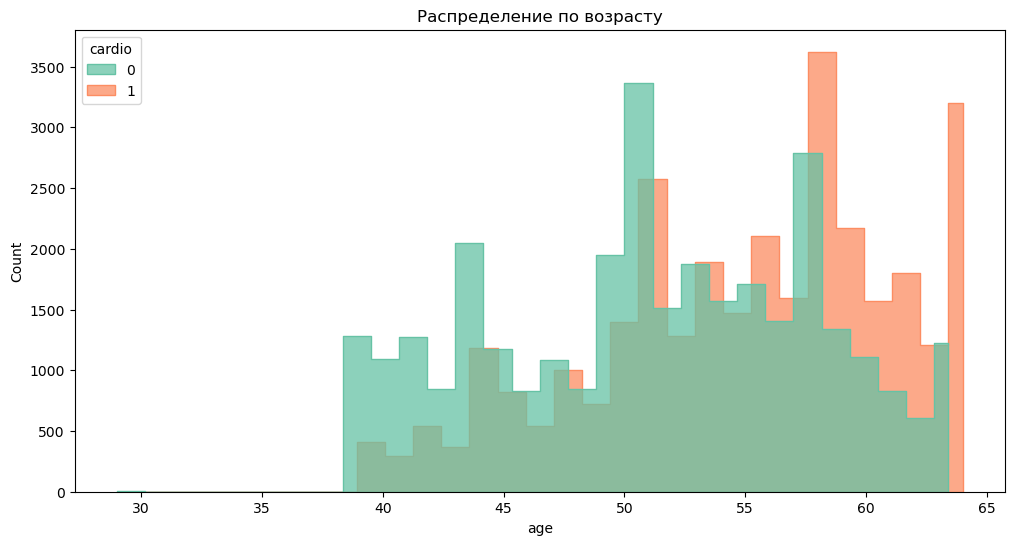

In [56]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='age', bins=30, hue='cardio', element="step", multiple="dodge", palette="Set2")
plt.title('Распределение по возрасту')
plt.show()

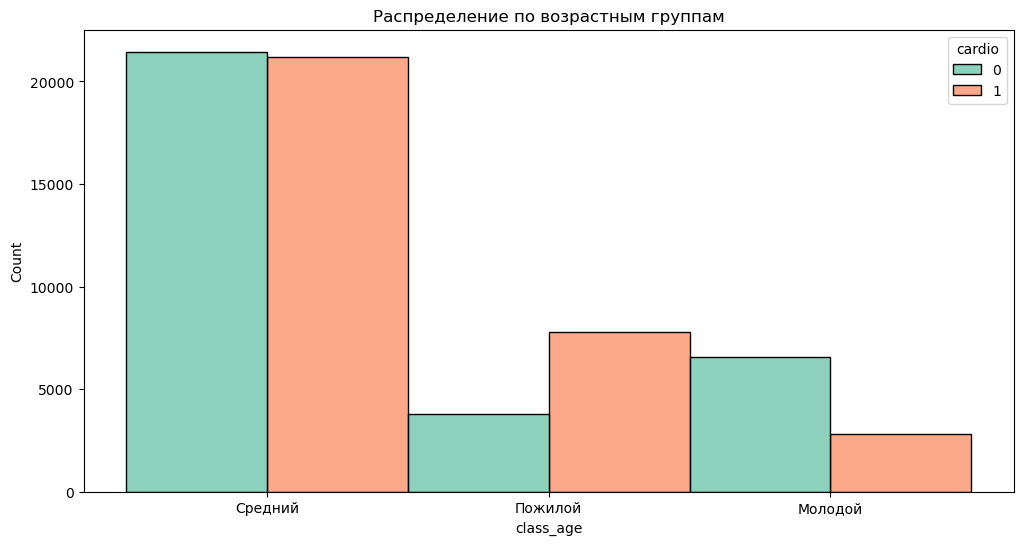

In [58]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='class_age', bins=5, hue='cardio', multiple="dodge", palette="Set2")
plt.title('Распределение по возрастным группам')
plt.show()

In [60]:
ag = [['9%', '67%', '24%'], ['20%', '68%', '12%']]
df_age = pd.DataFrame(ag, columns=['Молодой', 'Средний', 'Пожилой'], index=['ССЗ', 'Без'])
df_age

,Молодой,Средний,Пожилой
ССЗ,9%,67%,24%
Без,20%,68%,12%


In [62]:
r_age = ttest_ind(df_c['age'], df_notc['age'])
print('p-value =', r_age.pvalue)

if (r_age.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

p-value = 0.0
Отвергаем нулевую гипотезу


Вывод:
Анализ данных показал, что с возрастом повышается риск развития сердечно-сосудистых заболеваний, при этом переломный момент наблюдается около 55 лет, когда количество пациентов с ССЗ начинает превышать число здоровых, а в группе пожилых отмечается значительное преобладание пациентов с диагностированными сердечно-сосудистыми заболеваниями.

1.2 Пол:

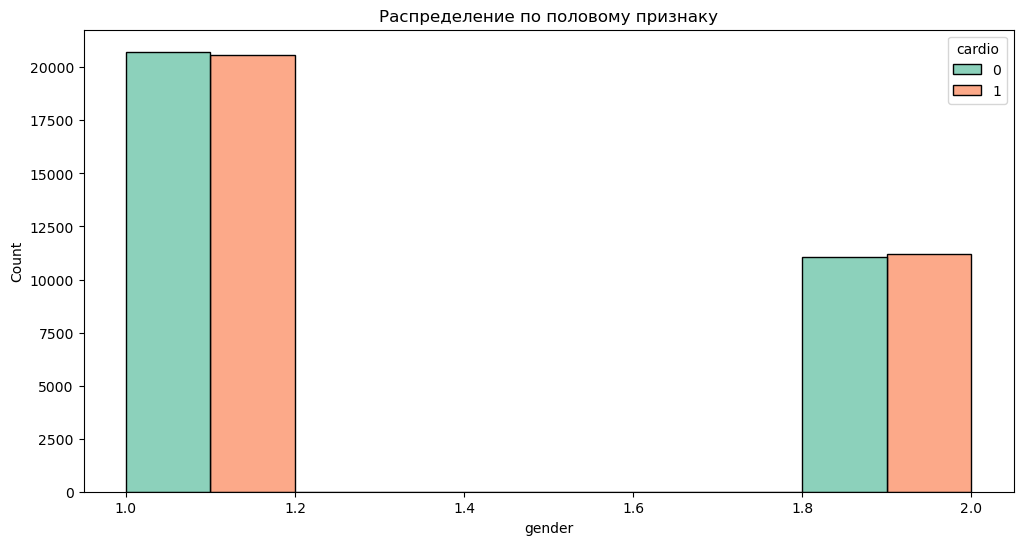

In [66]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='gender', bins=5, hue='cardio', multiple="dodge", palette="Set2")
plt.title('Распределение по половому признаку')
plt.show()

In [68]:
g = [['65%', '35%'], ['65%', '35%']]
df_gender = pd.DataFrame(g, columns=['Женщины', 'Мужчины'], index=['ССЗ', 'Без'])
df_gender

,Женщины,Мужчины
ССЗ,65%,35%
Без,65%,35%


In [70]:
r_gender = ttest_ind(df_c['gender'], df_notc['gender'])
print('p-value =', r_gender.pvalue)

if (r_gender.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

p-value = 0.1778772419187124
Не отвергаем нулевую гипотезу


Вывод: Результаты демонстрируют, что как среди мужской, так и среди женской выборки пациентов распределение случаев ССЗ происходит без существенной зависимости от пола. Это означает, что гендерный фактор сам по себе не может рассматриваться как значимый предиктор риска развития сердечно-сосудистых заболеваний.

1.3 Рост:

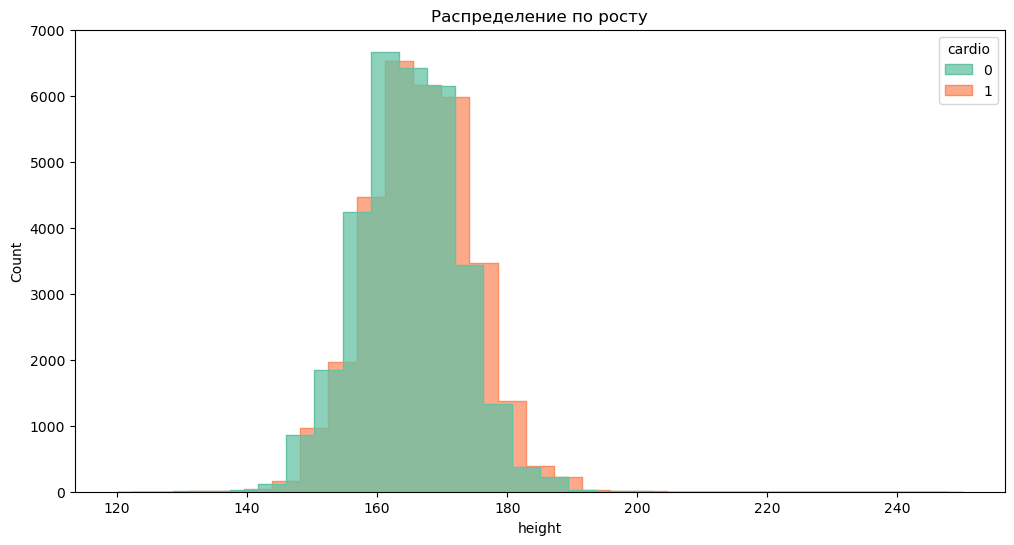

In [74]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='height', bins=30, hue='cardio', element="step", multiple="dodge", palette="Set2")
plt.title('Распределение по росту')
plt.show()

In [76]:
r_height = ttest_ind(df_c['height'], df_notc['height'])
print('p-value =', r_height.pvalue)

if (r_height.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

p-value = 0.00590021921825544
Отвергаем нулевую гипотезу


Вывод: Проведённый графический анализ в сочетании с применением Т-критерия не выявил существенной корреляционной связи между антропометрическим показателем роста и вероятностью развития сердечно-сосудистых заболеваний. Наблюдаемая в ходе статистической обработки слабая взаимосвязь между ростом и ССЗ может быть обусловлена влиянием индекса массы тела на оба показателя, то есть носит косвенный характер, а не является прямым фактором риска.

1.4 Вес:

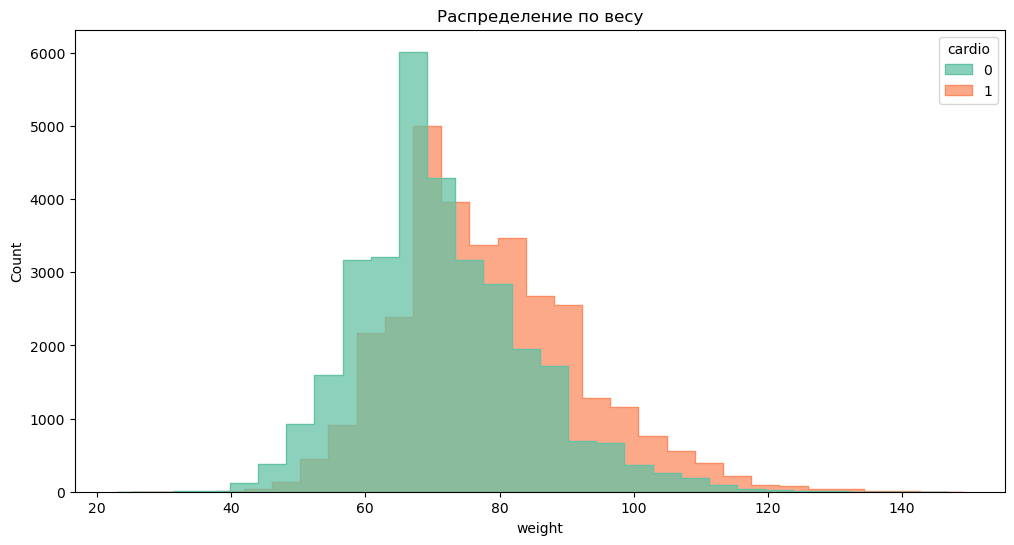

In [80]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='weight', bins=30, hue='cardio', element="step", multiple="dodge", palette="Set2")
plt.title('Распределение по весу')
plt.show()

In [82]:
r_weight = ttest_ind(df_c['weight'], df_notc['weight'])
print('p-value =', r_weight.pvalue)

if (r_weight.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

p-value = 0.0
Отвергаем нулевую гипотезу


Вывод: Статистический анализ данных (включая графический анализ и Т-критерий) выявил закономерность: среди пациентов с массой тела 80 кг и выше отмечается преобладание лиц с диагностированными сердечно-сосудистыми заболеваниями над здоровыми.

1.5 ИМТ:

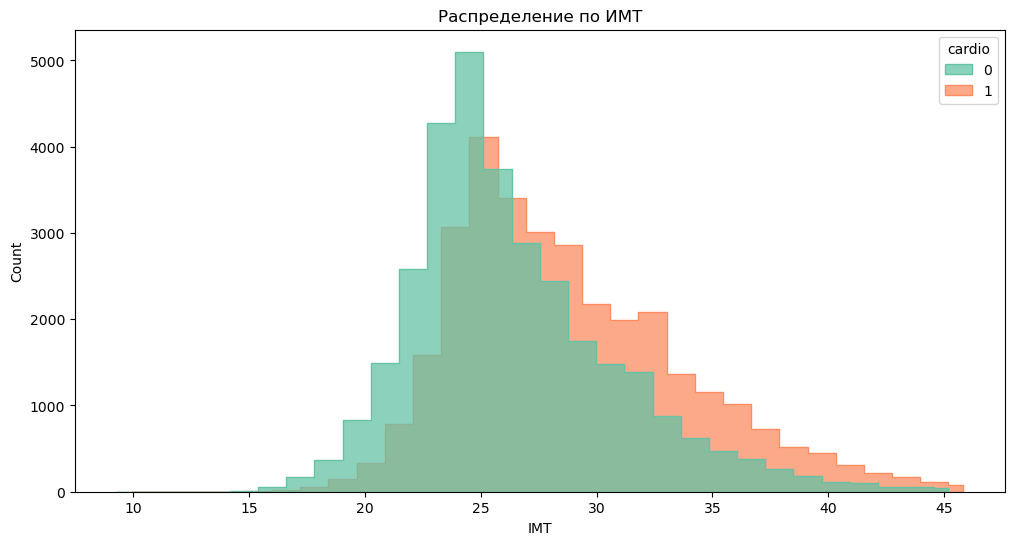

In [86]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='IMT', bins=30, hue='cardio', element="step", multiple="dodge", palette="Set2")
plt.title('Распределение по ИМТ')
plt.show()

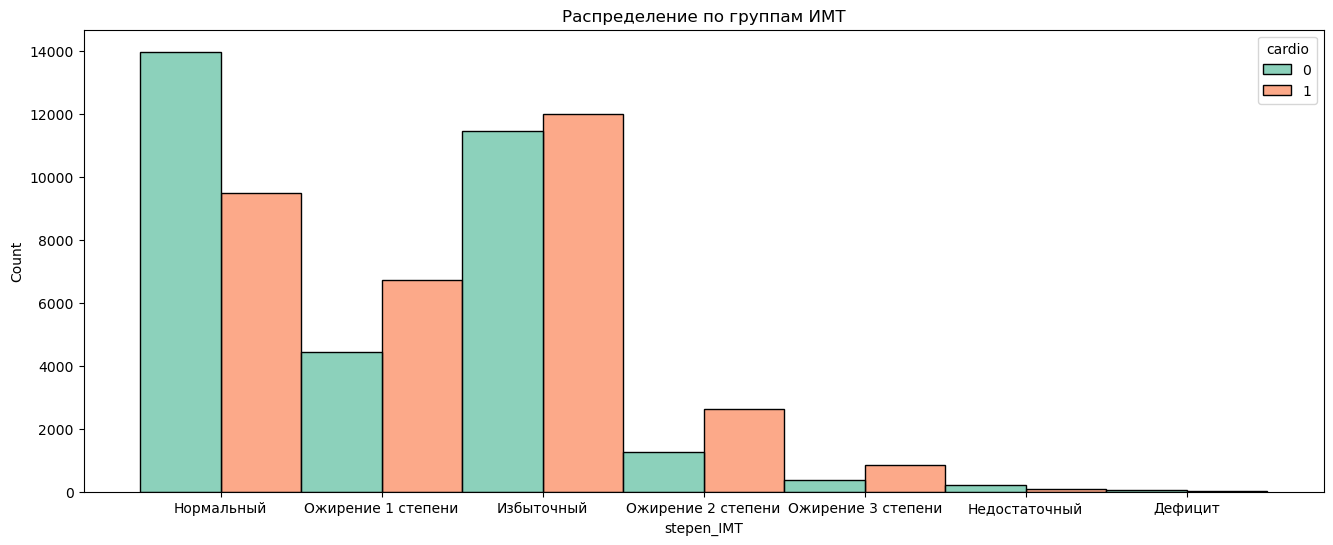

In [88]:
plt.figure(figsize=(16, 6))
sns.histplot(data=df, x='stepen_IMT', bins = 30, hue='cardio', multiple="dodge", palette="Set2")
plt.title('Распределение по группам ИМТ')
plt.show()

In [90]:
imt = [['<1%', '<1%', '30%', '38%', '21%', '8%', '3%'], ['<1%', '1%', '44%', '36%', '14%', '4%', '1%']]
df_IMT = pd.DataFrame(imt, columns=['Дефицит', 'Недостаточный', 'Нормальный', 'Избыточный', 'Ожирение 1 степени', 'Ожирение 2 степени', 'Ожирение 3 степени'], index=['ССЗ', 'Без'])
df_IMT

,Дефицит,Недостаточный,Нормальный,Избыточный,Ожирение 1 степени,Ожирение 2 степени,Ожирение 3 степени
ССЗ,<1%,<1%,30%,38%,21%,8%,3%
Без,<1%,1%,44%,36%,14%,4%,1%


In [92]:
r_imt = ttest_ind(df_c['IMT'], df_notc['IMT'])
print('p-value =', r_imt.pvalue)

if (r_imt.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

p-value = 0.0
Отвергаем нулевую гипотезу


Вывод: Анализ графических данных и т-критерия выявил прямую корреляцию между индексом массы тела (ИМТ) и вероятностью диагностики сердечно-сосудистых заболеваний: при достижении показателя в 27 единиц количество пациентов с ССЗ начинает превышать число здоровых.

2. Взаимосвязь ССЗ с диагностическими признаками:

2.1 Давление:

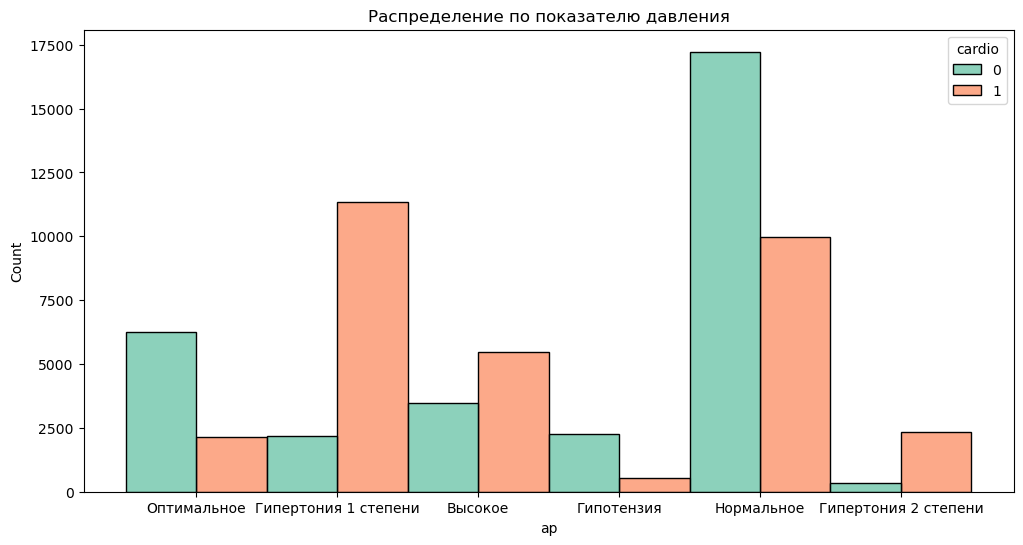

In [97]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='ap', bins=5, hue='cardio', multiple="dodge", palette="Set2")
plt.title('Распределение по показателю давления')
plt.show()

In [99]:
ap = [['2%', '7%', '31%', '17%', '36%', '7%'], ['7%', '20%', '54%', '11%', '7%', '1%']]
df_ap = pd.DataFrame(ap, columns=['Гипотензия', 'Оптимальное', 'Нормальное', 'Высокое', 'Гипертония 1 степени', 'Гипертония 2 степени'], index=['ССЗ', 'Без'])
df_ap

,Гипотензия,Оптимальное,Нормальное,Высокое,Гипертония 1 степени,Гипертония 2 степени
ССЗ,2%,7%,31%,17%,36%,7%
Без,7%,20%,54%,11%,7%,1%


In [101]:
r_ap = ttest_ind(df_c['ap_hi'], df_notc['ap_hi'])
print('p-value =', r_ap.pvalue)

if (r_ap.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

p-value = 0.0
Отвергаем нулевую гипотезу


Графическая визуализация данных и Т-критерий показывают, что уже в группе с высоким давлением количество пациентов с сердечно-сосудистыми заболеваниями значительно превышает число здоровых. Это подтверждает прямую взаимосвязь между показателями артериального давления и риском развития сердечно-сосудистых заболеваний.

2.2 Холестирин:

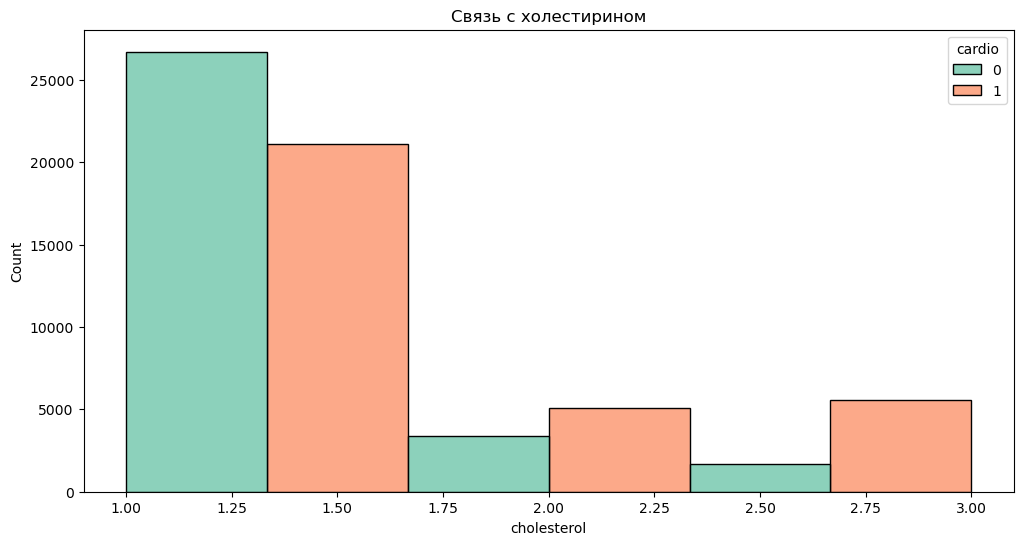

In [105]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='cholesterol', bins=3, hue='cardio', multiple="dodge", palette="Set2")
plt.title('Связь с холестирином')
plt.show()

In [107]:
h = [['66%', '16%', '18%'], ['84%', '11%', '5%']]
df_hol = pd.DataFrame(h, columns=['Нормальный', 'Повышеный', 'Высокий'], index=['ССЗ', 'Без'])
df_hol

,Нормальный,Повышеный,Высокий
ССЗ,66%,16%,18%
Без,84%,11%,5%


In [109]:
r_hol = ttest_ind(df_c['cholesterol'], df_notc['cholesterol'])
print('p-value =', r_hol.pvalue)

if (r_hol.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

p-value = 0.0
Отвергаем нулевую гипотезу


Вывод: Исследование, основанное на графическом анализе и Т-критерии, показало выраженную корреляцию между уровнем холестерина и частотой выявления сердечно-сосудистых заболеваний.
Анализ данных свидетельствует: чем выше показатели холестерина, тем чаще диагностируются ССЗ, что подтверждает значимость повышенного холестерина как фактора риска развития сердечно-сосудистых патологий.

2.3 Глюкоза:

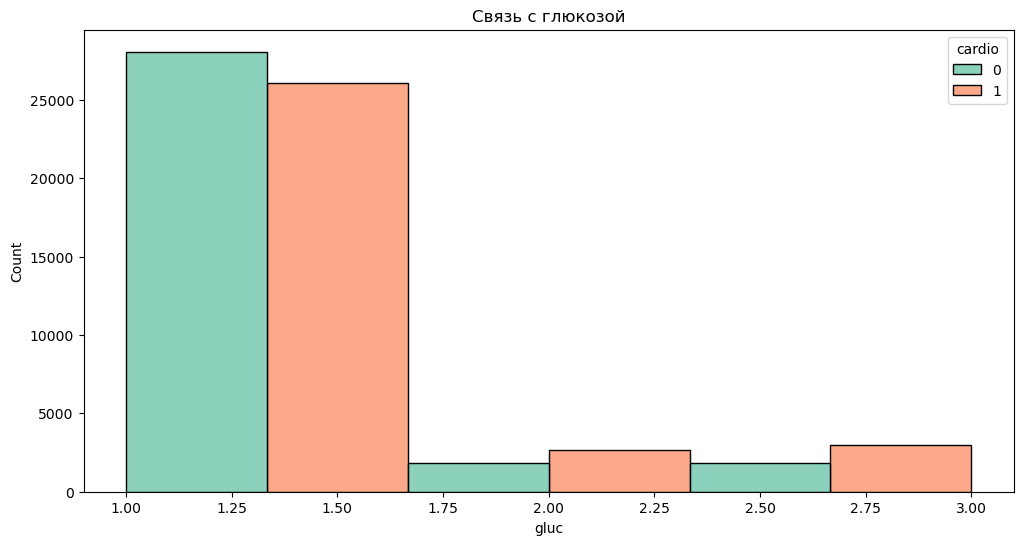

In [113]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='gluc', bins=3, hue='cardio', multiple="dodge", palette="Set2")
plt.title('Связь с глюкозой')
plt.show()

In [115]:
gl = [['82%', '8%', '9%'], ['88%', '6%', '6%']]
df_gluc = pd.DataFrame(gl, columns=['Нормальная', 'Повышеная', 'Высокая'], index=['ССЗ', 'Без'])
df_gluc

,Нормальная,Повышеная,Высокая
ССЗ,82%,8%,9%
Без,88%,6%,6%


In [117]:
r_gluc = ttest_ind(df_c['gluc'], df_notc['gluc'])
print('p-value =', r_gluc.pvalue)

if (r_gluc.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

p-value = 8.194708638433635e-106
Отвергаем нулевую гипотезу


Вывод: Анализ показал, что при достижении уровня повышенной глюкозы в крови отмечается небольшое преобладание количества пациентов с диагностированными сердечно-сосудистыми заболеваниями над здоровыми, что указывает на наличие связи между гипергликемией и риском развития ССЗ.

3. Взаимосвязь ССЗ с образом жизни:

3.1 Курение:

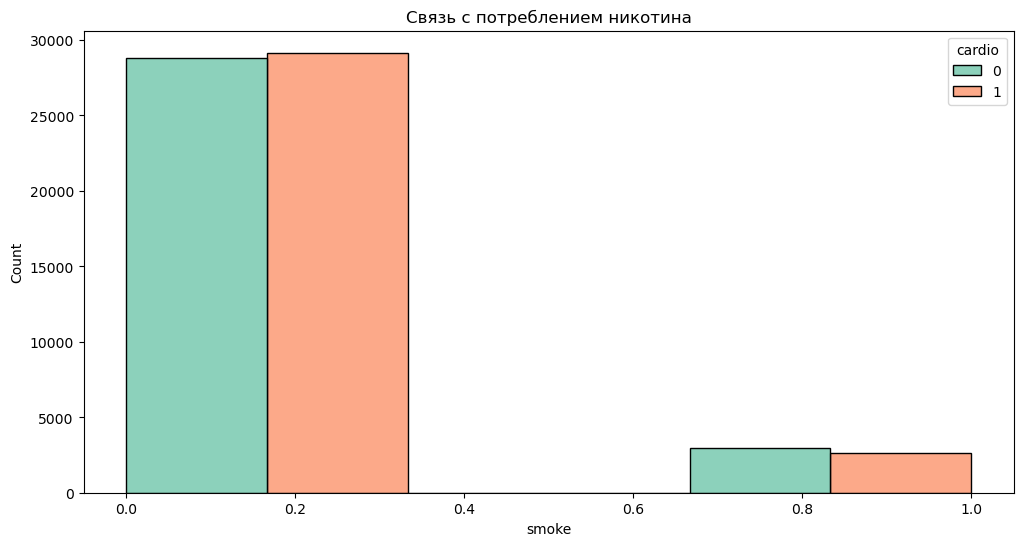

In [122]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='smoke', bins = 3, hue='cardio', multiple="dodge", palette="Set2")
plt.title('Связь с потреблением никотина')
plt.show()

In [124]:
s = [['92%', '8%'], ['91%', '9%']]
df_smoke = pd.DataFrame(s, columns=['Некурящие', 'Курящие'], index=['ССЗ', 'Без'])
df_smoke

,Некурящие,Курящие
ССЗ,92%,8%
Без,91%,9%


In [126]:
r_smoke = ttest_ind(df_c['smoke'], df_notc['smoke'])
print('p-value =', r_smoke.pvalue)

if (r_smoke.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

p-value = 8.689123876667961e-06
Отвергаем нулевую гипотезу


Вывод: Исследование с использованием графиков и Т-критерия показало наличие некой зависимости между курением и вероятностью развития ССЗ, но установить существенную корреляцию не удалось.

3.2 Алкоголь:

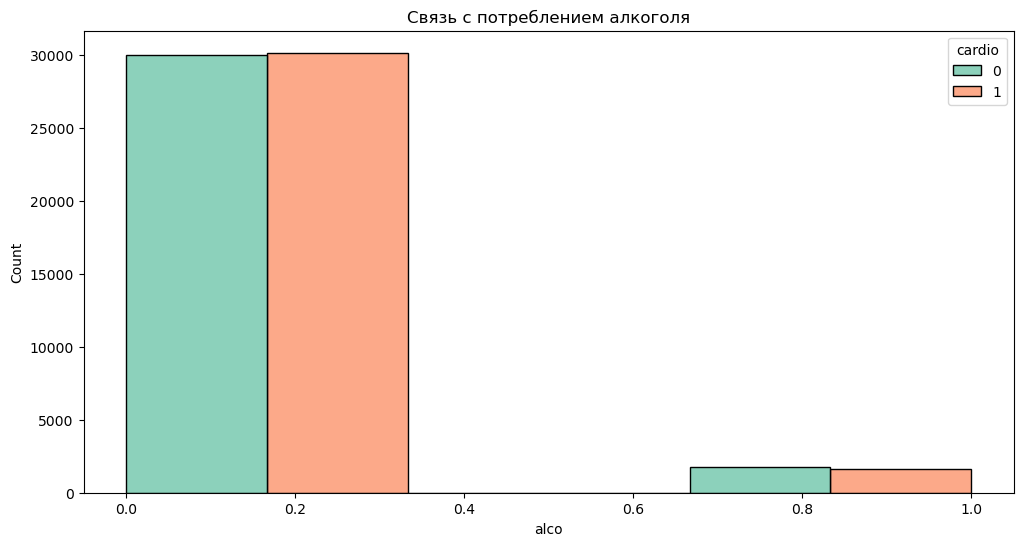

In [130]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='alco', bins = 3, hue='cardio', multiple="dodge", palette="Set2")
plt.title('Связь с потреблением алкоголя')
plt.show()

In [132]:
a = [['95%', '5%'], ['95%', '5%']]
df_alco = pd.DataFrame(a, columns=['Непьющие', 'Пьющие'], index=['ССЗ', 'Без'])
df_alco

,Непьющие,Пьющие
ССЗ,95%,5%
Без,95%,5%


In [134]:
r_alco = ttest_ind(df_c['alco'], df_notc['alco'])
print('p-value =', r_alco.pvalue)

if (r_alco.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

p-value = 0.013566955101029248
Отвергаем нулевую гипотезу


Вывод: Статистический анализ (включая графический и Т-критерий) не выявил существенной взаимосвязи между употреблением алкоголя и риском развития сердечно-сосудистых заболеваний.

3.3 Физическая активность:

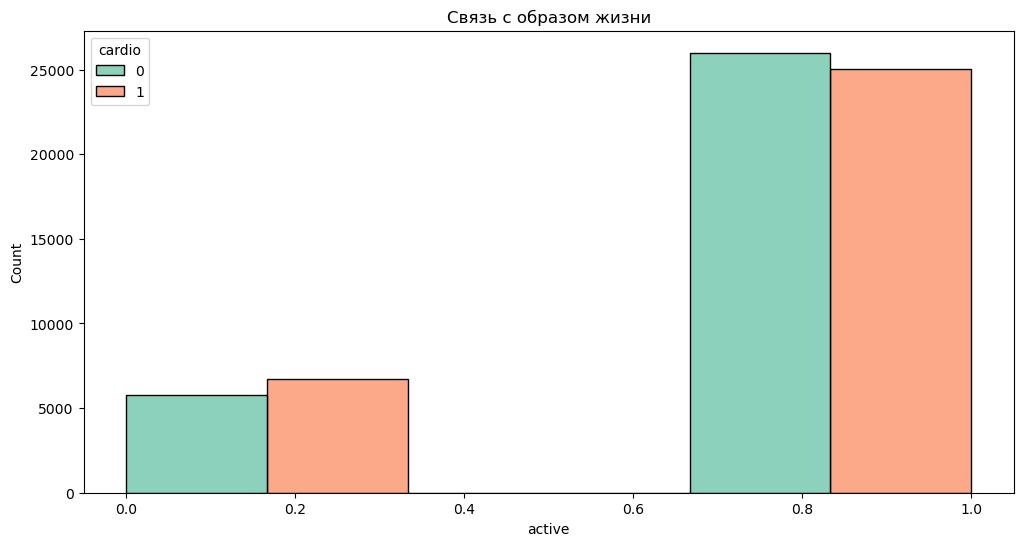

In [138]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='active', bins = 3, hue='cardio', multiple="dodge", palette="Set2")
plt.title('Связь с образом жизни')
plt.show()

In [140]:
f = [['79%', '21%'], ['82%', '18%']]
df_active = pd.DataFrame(f, columns=['Ведущие', 'Неведущие'], index=['ССЗ', 'Без'])
df_active

,Ведущие,Неведущие
ССЗ,79%,21%
Без,82%,18%


In [142]:
r_ac = ttest_ind(df_c['active'], df_notc['active'])
print('p-value =', r_ac.pvalue)

if (r_ac.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

p-value = 5.293096588842994e-21
Отвергаем нулевую гипотезу


Вывод: Статистический анализ данных с использованием Т-критерия подтверждает наличие связи между уровнем физической активности и вероятностью развития сердечно-сосудистых заболеваний. Однако детальный анализ, выполненный с помощью графиков и таблиц, показывает, что различия между группами с разной физической активностью выражены незначительно.

Построение и оценка модели Логистической Регрессии:

1. Разделение на обучающую и тестовую выборки

In [147]:
x = df1.drop('cardio', axis = 1)
y = df1['cardio']

In [149]:
x_tr, x_te, y_tr, y_te = train_test_split(x, y, test_size = 0.2, random_state = 42, stratify = y)

2. Вычесление скаляра

In [152]:
scal = StandardScaler()
x_tr_s = scal.fit_transform(x_tr)
x_te_s = scal.transform(x_te)

3. Обучение модели

In [155]:
model = LogisticRegression(C=1.0, solver = 'liblinear', random_state = 42)
model.fit(x_tr_s, y_tr)

LogisticRegression(random_state=42, solver='liblinear')

In [157]:
y_pr_tr = model.predict(x_tr_s)
y_pr_p_tr = model.predict_proba(x_tr_s)[:, 1]

In [161]:
ac_tr = accuracy_score(y_tr, y_pr_tr)
print('Точность модели:', round(ac_tr, 2))

Точность модели: 0.72


4. Прогнозирование и проверка

In [164]:
y_pr_te = model.predict(x_te_s)
y_pr_p_te = model.predict_proba(x_te_s)[:, 1]

In [166]:
ac_te = accuracy_score(y_te, y_pr_te)
print('Точность модели:', round(ac_te, 2))

roc_auc = roc_auc_score(y_te, y_pr_p_te)
print('ROC AUC:', round(roc_auc, 2))

Точность модели: 0.73
ROC AUC: 0.79


5. Визуализация

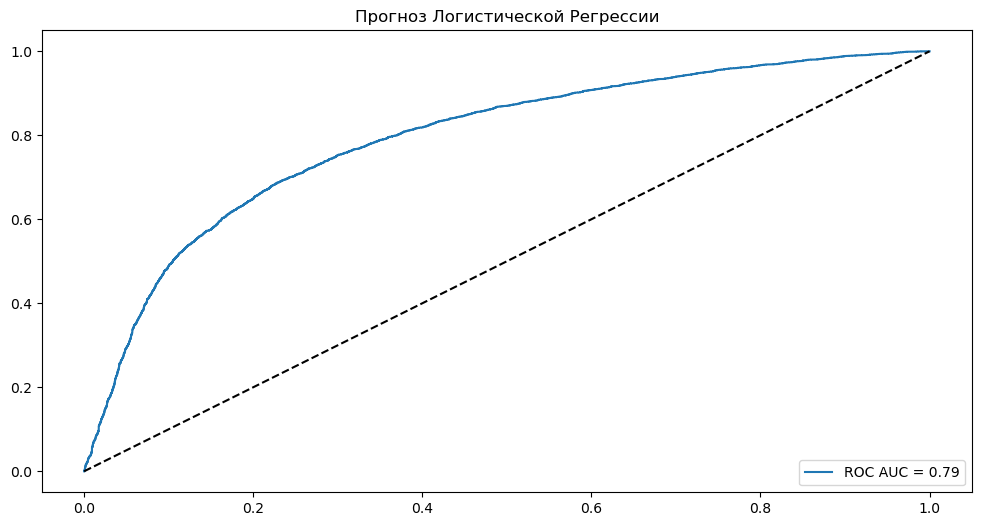

In [171]:
fpr, tpr, thr = roc_curve(y_te, y_pr_p_te)
plt.figure(figsize = (12, 6))
plt.title('Прогноз Логистической Регрессии')
plt.plot(fpr, tpr, label = 'ROC AUC = 0.79')
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(loc = 'lower right')
plt.show() 

Общий вывод:

Исследование достоверно подтвердило значимость избыточного веса и повышенного артериального давления как ключевых факторов риска развития ССЗ. В рамках работы была создана единая система метрик для лабораторной практики, существенно улучшающая оценку рисков сердечно-сосудистых заболеваний.
Практическая значимость исследования заключается в том, что разработанные модели позволяют медицинским специалистам своевременно выявлять пациентов группы риска, проводить более эффективную раннюю диагностику и оптимизировать профилактические мероприятия. Полученные результаты могут быть успешно использованы для совершенствования системы профилактики и диагностики сердечно-сосудистых заболеваний, что в конечном итоге способствует повышению качества медицинского наблюдения и улучшению исходов лечения пациентов.
